# 1: 기본 설정 및 환경 확인

In [83]:
import os
import sys
import warnings
import math
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import wandb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

from pathlib import Path

# 머신러닝 모델들
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 부스팅 모델들
try:
    from xgboost import XGBClassifier
    print("✅ XGBoost 로드 성공")
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️ XGBoost 설치 필요: pip install xgboost")
    XGBOOST_AVAILABLE = False

try:
    from lightgbm import LGBMClassifier
    print("✅ LightGBM 로드 성공")
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("⚠️ LightGBM 설치 필요: pip install lightgbm")
    LIGHTGBM_AVAILABLE = False

# try:
#     from catboost import CatBoostClassifier
#     print("✅ CatBoost 로드 성공")
#     CATBOOST_AVAILABLE = True
# except ImportError:
#     print("⚠️ CatBoost 설치 필요: pip install catboost")
#     CATBOOST_AVAILABLE = False

print("🔧 환경 설정 및 WandB 초기화")
print("=" * 60)

✅ XGBoost 로드 성공
✅ LightGBM 로드 성공
🔧 환경 설정 및 WandB 초기화


In [ ]:
# ============================================================
# 1. .env 파일 직접 파싱 및 환경변수 설정
# ============================================================
current_dir = Path(os.getcwd())
project_root = current_dir.parent
env_path = project_root / '.env'

print(f"📂 프로젝트 루트: {project_root}")
print(f"📄 .env 경로: {env_path}")

# 환경변수 직접 로드
env_vars = {}
if env_path.exists():
    print("✅ .env 파일 발견 - BOM 제거 파싱 중...")
    try:
        # 핵심 해결책: utf-8-sig 인코딩으로 BOM 자동 제거
        with open(env_path, 'r', encoding='utf-8-sig') as f:
            for line_num, line in enumerate(f, 1):
                line = line.strip()
                
                # 빈 줄이나 주석 무시
                if not line or line.startswith('#'):
                    continue
                
                # KEY=VALUE 형식 파싱
                if '=' in line:
                    key, value = line.split('=', 1)
                    key = key.strip()
                    value = value.strip()
                    
                    # 추가 안전장치: 보이지 않는 문자들 제거
                    key = key.replace('\ufeff', '').replace('\u200b', '').replace('\u2060', '')
                    value = value.replace('\ufeff', '').replace('\u200b', '').replace('\u2060', '')
                    
                    # 따옴표 제거
                    if (value.startswith('"') and value.endswith('"')) or \
                       (value.startswith("'") and value.endswith("'")):
                        value = value[1:-1]
                    
                    # 환경변수에 설정
                    os.environ[key] = value
                    env_vars[key] = value
                    
                    # 로그 출력 (이제 정상적으로 마스킹됨)
                    if key == 'WANDB_API_KEY':
                        print(f"  ✅ {key}: {value[:8]}****** (길이: {len(value)}) - BOM 제거 성공!")
                    else:
                        print(f"  ✅ {key}: {value}")
                else:
                    print(f"  ⚠️ 라인 {line_num} 형식 오류: {line}")
                    
        print(f"\n📊 총 {len(env_vars)}개 환경변수 로드 완료")
        
    except Exception as e:
        print(f"❌ .env 파일 읽기 오류: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ .env 파일을 찾을 수 없습니다.")

📂 프로젝트 루트: c:\Users\ico26\kaggle\Heart Disease
📄 .env 경로: c:\Users\ico26\kaggle\Heart Disease\.env
✅ .env 파일 발견 - BOM 제거 파싱 중...
  ✅ WANDB_API_KEY: wandb_v1****** (길이: 86) - BOM 제거 성공!
  ✅ WANDB_PROJECT: heart-disease-prediction
  ✅ WANDB_ENTITY: icoghkdqh742-

📊 총 3개 환경변수 로드 완료


In [5]:
# ============================================================
# 2. 환경변수 로드 및 검증
# ============================================================
WANDB_API_KEY = os.environ.get('WANDB_API_KEY')
WANDB_PROJECT = os.environ.get('WANDB_PROJECT', 'heart-disease-prediction')
WANDB_ENTITY = os.environ.get('WANDB_ENTITY', None)

print(f"\n🔐 최종 인증 정보:")
print(f"  📁 Project: {WANDB_PROJECT}")
print(f"  👤 Entity: {WANDB_ENTITY}")

# API Key 검증 및 대체 입력
if not WANDB_API_KEY or len(WANDB_API_KEY.strip()) == 0:
    print("  ❌ API Key: 없음 또는 빈 값")
    print("\n" + "="*50)
    print("💡 API Key 수동 입력")
    print("="*50)
    
    from getpass import getpass
    WANDB_API_KEY = getpass("WandB API Key를 입력하세요 (입력 내용 숨김): ").strip()
    
    if not WANDB_API_KEY:
        raise ValueError("API Key가 필요합니다.")
    
    print(f"✅ 수동 입력 완료: {WANDB_API_KEY[:8]}******")
else:
    print(f"  ✅ API Key: {WANDB_API_KEY[:8]}****** (길이: {len(WANDB_API_KEY)})")


🔐 최종 인증 정보:
  📁 Project: heart-disease-prediction
  👤 Entity: icoghkdqh742-
  ✅ API Key: wandb_v1****** (길이: 86)


In [3]:
# ============================================================
# 3. WandB 오프라인 모드 강제 해제
# ============================================================
print(f"\n🔧 WandB 설정 정리...")

# 기존 WandB 실행 종료
if wandb.run is not None:
    wandb.finish()
    print("  🧹 이전 WandB 실행 종료")

# 오프라인 모드 관련 환경변수 제거
problematic_vars = ['WANDB_MODE', 'WANDB_DISABLED', 'WANDB_SILENT']
for var in problematic_vars:
    if var in os.environ:
        print(f"  🗑️ 제거: {var}={os.environ[var]}")
        del os.environ[var]

# 강제 온라인 모드 설정
os.environ['WANDB_MODE'] = 'online'
print("  ✅ 온라인 모드 강제 설정")

# notebooks/wandb 폴더 확인 (오프라인 설정 캐시)
wandb_cache_dir = current_dir / 'wandb'
if wandb_cache_dir.exists():
    print(f"  ⚠️ WandB 캐시 폴더 발견: {wandb_cache_dir}")
    print("  💡 오프라인 모드 문제 시 이 폴더를 삭제하세요")


🔧 WandB 설정 정리...
  ✅ 온라인 모드 강제 설정


In [9]:
# ============================================================
# 4. WandB 로그인 및 초기화
# ============================================================
try:
    print(f"\n🔐 WandB 로그인 시도...")
    wandb.login(key=WANDB_API_KEY, relogin=True)
    print("✅ WandB 로그인 성공!")
    
except Exception as e:
    print(f"❌ 로그인 실패: {e}")
    print("💡 계속 진행하여 init에서 재시도합니다...")

# 실험 설정
config = {
    'project_name': WANDB_PROJECT,
    'model_type': 'tabular',
    'batch_size': 64,
    'learning_rate': 0.001,
    'epochs': 100,
    'optimizer': 'Adam',
    'loss_function': 'BCEWithLogitsLoss',
    'hidden_dims': [256, 128, 64, 32],
    'dropout_rate': 0.3,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# WandB 초기화
print(f"\n🚀 WandB 실험 초기화...")
try:
    run = wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        config=config,
        name=f"heart_disease_exp_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}",
        notes="Heart disease prediction using tabular neural network",
        tags=["pytorch", "tabular", "classification", "heart-disease"],
        save_code=True,
        mode="online",  # 명시적 온라인 모드
        reinit=True,
        settings=wandb.Settings(
            start_method="thread",  # Windows 호환성
            _disable_stats=False,
        )
    )
    print("✅ WandB 초기화 성공!")
    
except Exception as e:
    print(f"❌ WandB 초기화 실패: {e}")
    print(f"에러 타입: {type(e).__name__}")
    
    # 상세 에러 출력
    import traceback
    print("\n📋 상세 에러 정보:")
    traceback.print_exc()
    
    # 대안 제시
    print(f"\n💡 해결 방법:")
    print(f"1. notebooks/wandb 폴더 삭제 후 커널 재시작")
    print(f"2. 터미널에서 'wandb login --relogin' 실행")
    print(f"3. VPN/방화벽 설정 확인")
    
    raise

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.



🔐 WandB 로그인 시도...
✅ WandB 로그인 성공!

🚀 WandB 실험 초기화...


✅ WandB 초기화 성공!


In [7]:
# ============================================================
# 5. 기본 환경 설정
# ============================================================
# GPU/CPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️ 사용 디바이스: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# 시드 고정
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 출력 디렉토리 생성
os.makedirs(project_root / 'outputs' / 'models', exist_ok=True)
os.makedirs(project_root / 'outputs' / 'submissions', exist_ok=True)



🖥️ 사용 디바이스: cuda
   GPU: NVIDIA GeForce RTX 4060 Ti


In [11]:
# ============================================================
# 6. 최종 결과 출력
# ============================================================
print("\n" + "=" * 80)
print("🎉 WandB 실험 추적 시작!")
print("=" * 80)
print(f"프로젝트: {WANDB_PROJECT}")
print(f"실험명: {run.name}")
print(f"실험 ID: {run.id}")
print(f"Entity: {WANDB_ENTITY}")

# URL 확인 및 출력
import time
print(f"\n⏳ 실험 URL 생성 대기...")
max_wait = 5
for i in range(max_wait):
    if run.url:
        break
    time.sleep(1)

if run.url:
    print(f"✅ 실험 추적 URL: {run.url}")
    print(f"\n🔗 브라우저에서 실시간 추적: {run.url}")
else:
    # 수동 URL 생성
    manual_url = f"https://wandb.ai/{WANDB_ENTITY}/{WANDB_PROJECT}/runs/{run.id}"
    print(f"📍 실험 URL (수동): {manual_url}")
    print(f"\n🔗 브라우저에서 확인: {manual_url}")

print("=" * 80)
print("✅ 모든 설정 완료! 이제 데이터 로드를 진행하세요.")

# WandB 모델 모니터링 준비
print(f"\n📊 실험 추적 준비 완료")


🎉 WandB 실험 추적 시작!
프로젝트: heart-disease-prediction
실험명: heart_disease_exp_20260213_130457
실험 ID: ztv9a8fs
Entity: icoghkdqh742-

⏳ 실험 URL 생성 대기...
✅ 실험 추적 URL: https://wandb.ai/icoghkdqh742-/heart-disease-prediction/runs/ztv9a8fs

🔗 브라우저에서 실시간 추적: https://wandb.ai/icoghkdqh742-/heart-disease-prediction/runs/ztv9a8fs
✅ 모든 설정 완료! 이제 데이터 로드를 진행하세요.

📊 실험 추적 준비 완료


# 데이터 로드 및 ERD
| 열 이름 | 설명 |
|------|------|
| **Age** | 환자의 나이(년) |
| **Sex** | 환자의 성별 ( 1 = 남성 , 0 = 여성 ) |
| **Chest pain type** | 흉통 유형: 1 = 전형적인 협심증 / 2 = 비전형적인 협심증 / 비협심증성 통증 / 4 = 무증상 |
| **BP** | 안정시 혈압(mmHg) |
| **Cholesterol** | 혈청 콜레스테롤 수치(mg/dL) |
| **FBS over 120** | 공복 혈당 > 120mg/dL ( 1 = 참 , 0 = 거짓 ) |
| **EKG results** | 안정시 심전도 결과: 0 = 정상 / 1 = ST-T파 이상 /2 = 좌심실 비대 |
| **Max HR** | 최대 심박수 달성 |
| **Exercise angina** | 운동 유발성 협심증 ( 1 = 예 , 0 = 아니오 ) |
| **ST depression** | 휴식 시 대비 운동으로 인한 ST 하강 |
| **Slope of ST** | 최대 운동 ST 구간의 기울기 |
| **Number of vessels fluro** | 형광투시법으로 색칠된 주요 혈관의 수(0~3개) |
| **Thallium** | 탈륨 스트레스 검사 결과 (범주형 의료 지표) |
| **Heart Disease** | Label :  Presence = 심장 질환 발견됨 / Absence = 심장 질환 없음|

In [ ]:
def data_load():
    train = pd.read_csv('../data/train.csv')
    test = pd.read_csv('../data/test.csv')
    submission_df = pd.read_csv('../data/sample_submission.csv')
    # Target Absence => 0 Presence =>1 로 변환
    train['Heart Disease'] = train['Heart Disease'].map({'Absence': 0, 'Presence': 1}).astype(int)
    return train, test, submission_df
train, test, submission_df = data_load()

In [61]:
print("기본 통계 요약:")
train.describe()

기본 통계 요약:


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873,0.448340
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007,0.497324
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000,0.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000,1.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


In [62]:
cat_cols = ['Sex', 'Chest pain type', 'FBS over 120',  'EKG results', 'Exercise angina', 'Slope of ST', 'Thallium', 'Number of vessels fluro']
num_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']

In [79]:
# 총 데이터 샘플 수
print(f"Total Train Samples: {len(train)}")
print(f"Total Test Samples: {len(test)}")
# 타겟 분포
print("\n타겟 분포:")
target_dist = train['Heart Disease'].value_counts()
print(train['Heart Disease'].value_counts(normalize=True))

Total Train Samples: 630000
Total Test Samples: 270000

타겟 분포:
Heart Disease
0    0.55166
1    0.44834
Name: proportion, dtype: float64


In [60]:
print('데이터 타입:')
print(train.dtypes)
print(f'\n결측치: {train.isnull().sum().sum()}')

데이터 타입:
id                           int64
Age                          int64
Sex                          int64
Chest pain type              int64
BP                           int64
Cholesterol                  int64
FBS over 120                 int64
EKG results                  int64
Max HR                       int64
Exercise angina              int64
ST depression              float64
Slope of ST                  int64
Number of vessels fluro      int64
Thallium                     int64
Heart Disease                int64
dtype: object

결측치: 0



🎯 타겟 변수와의 상관관계 (상위 10개):
                    Age        BP  Cholesterol    Max HR  ST depression  \
Age            1.000000 -0.003960     0.019485 -0.097542       0.103064   
BP            -0.003960  1.000000    -0.004597  0.004391      -0.004024   
Cholesterol    0.019485 -0.004597     1.000000 -0.048575       0.044678   
Max HR        -0.097542  0.004391    -0.048575  1.000000      -0.229462   
ST depression  0.103064 -0.004024     0.044678 -0.229462       1.000000   
Heart Disease  0.212091 -0.005181     0.082753 -0.440985       0.430641   

               Heart Disease  
Age                 0.212091  
BP                 -0.005181  
Cholesterol         0.082753  
Max HR             -0.440985  
ST depression       0.430641  
Heart Disease       1.000000  


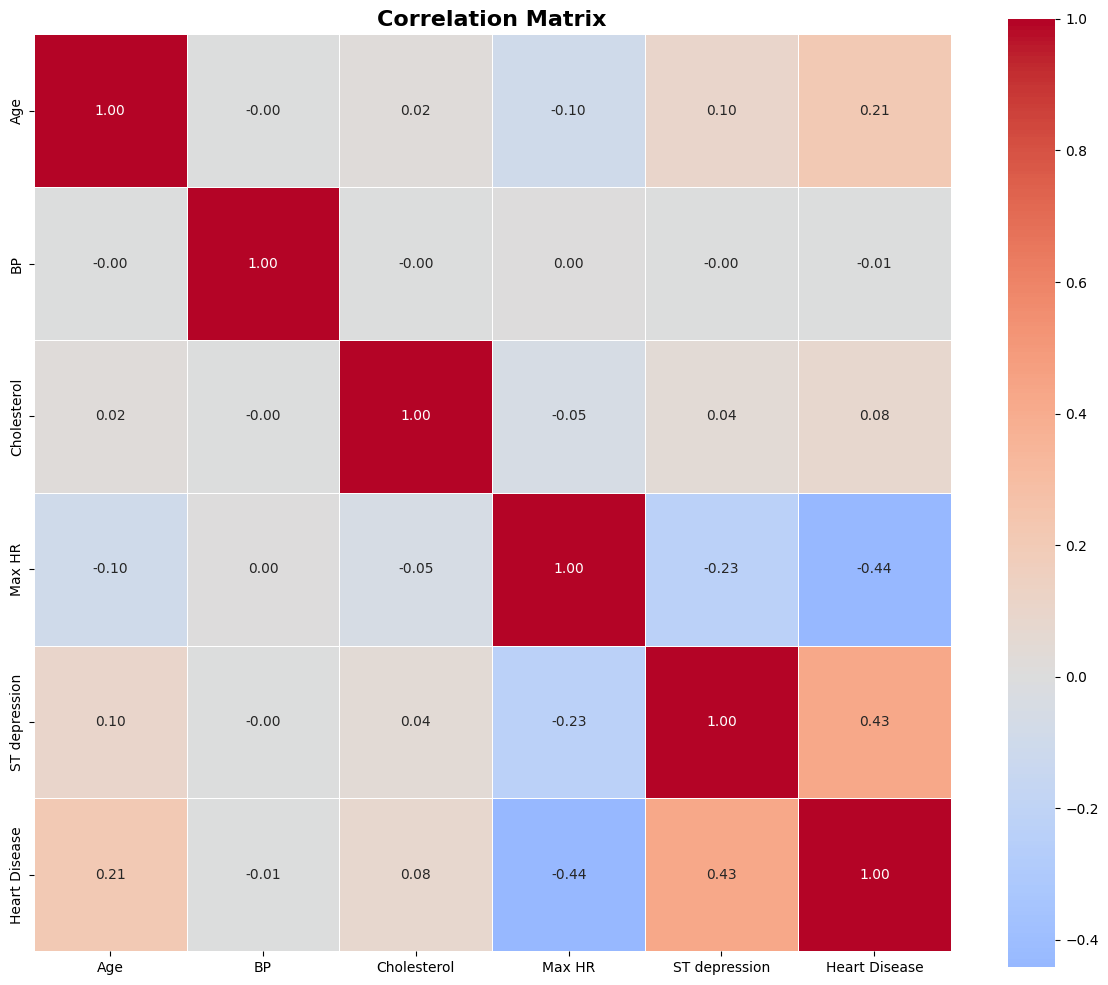

<Figure size 640x480 with 0 Axes>

In [ ]:
# 상관계수 계산
correlation_matrix = train[num_cols+["Heart Disease"]].corr()

# 타겟과의 상관관계
target_corr = train["Heart Disease"].sort_values(ascending=False)
print(f"\n타겟 변수와의 상관관계 (상위 10개):")
print(correlation_matrix.head(10))

# 상관관계 히트맵
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    # mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"correlation_matrix": wandb.Image(plt)})

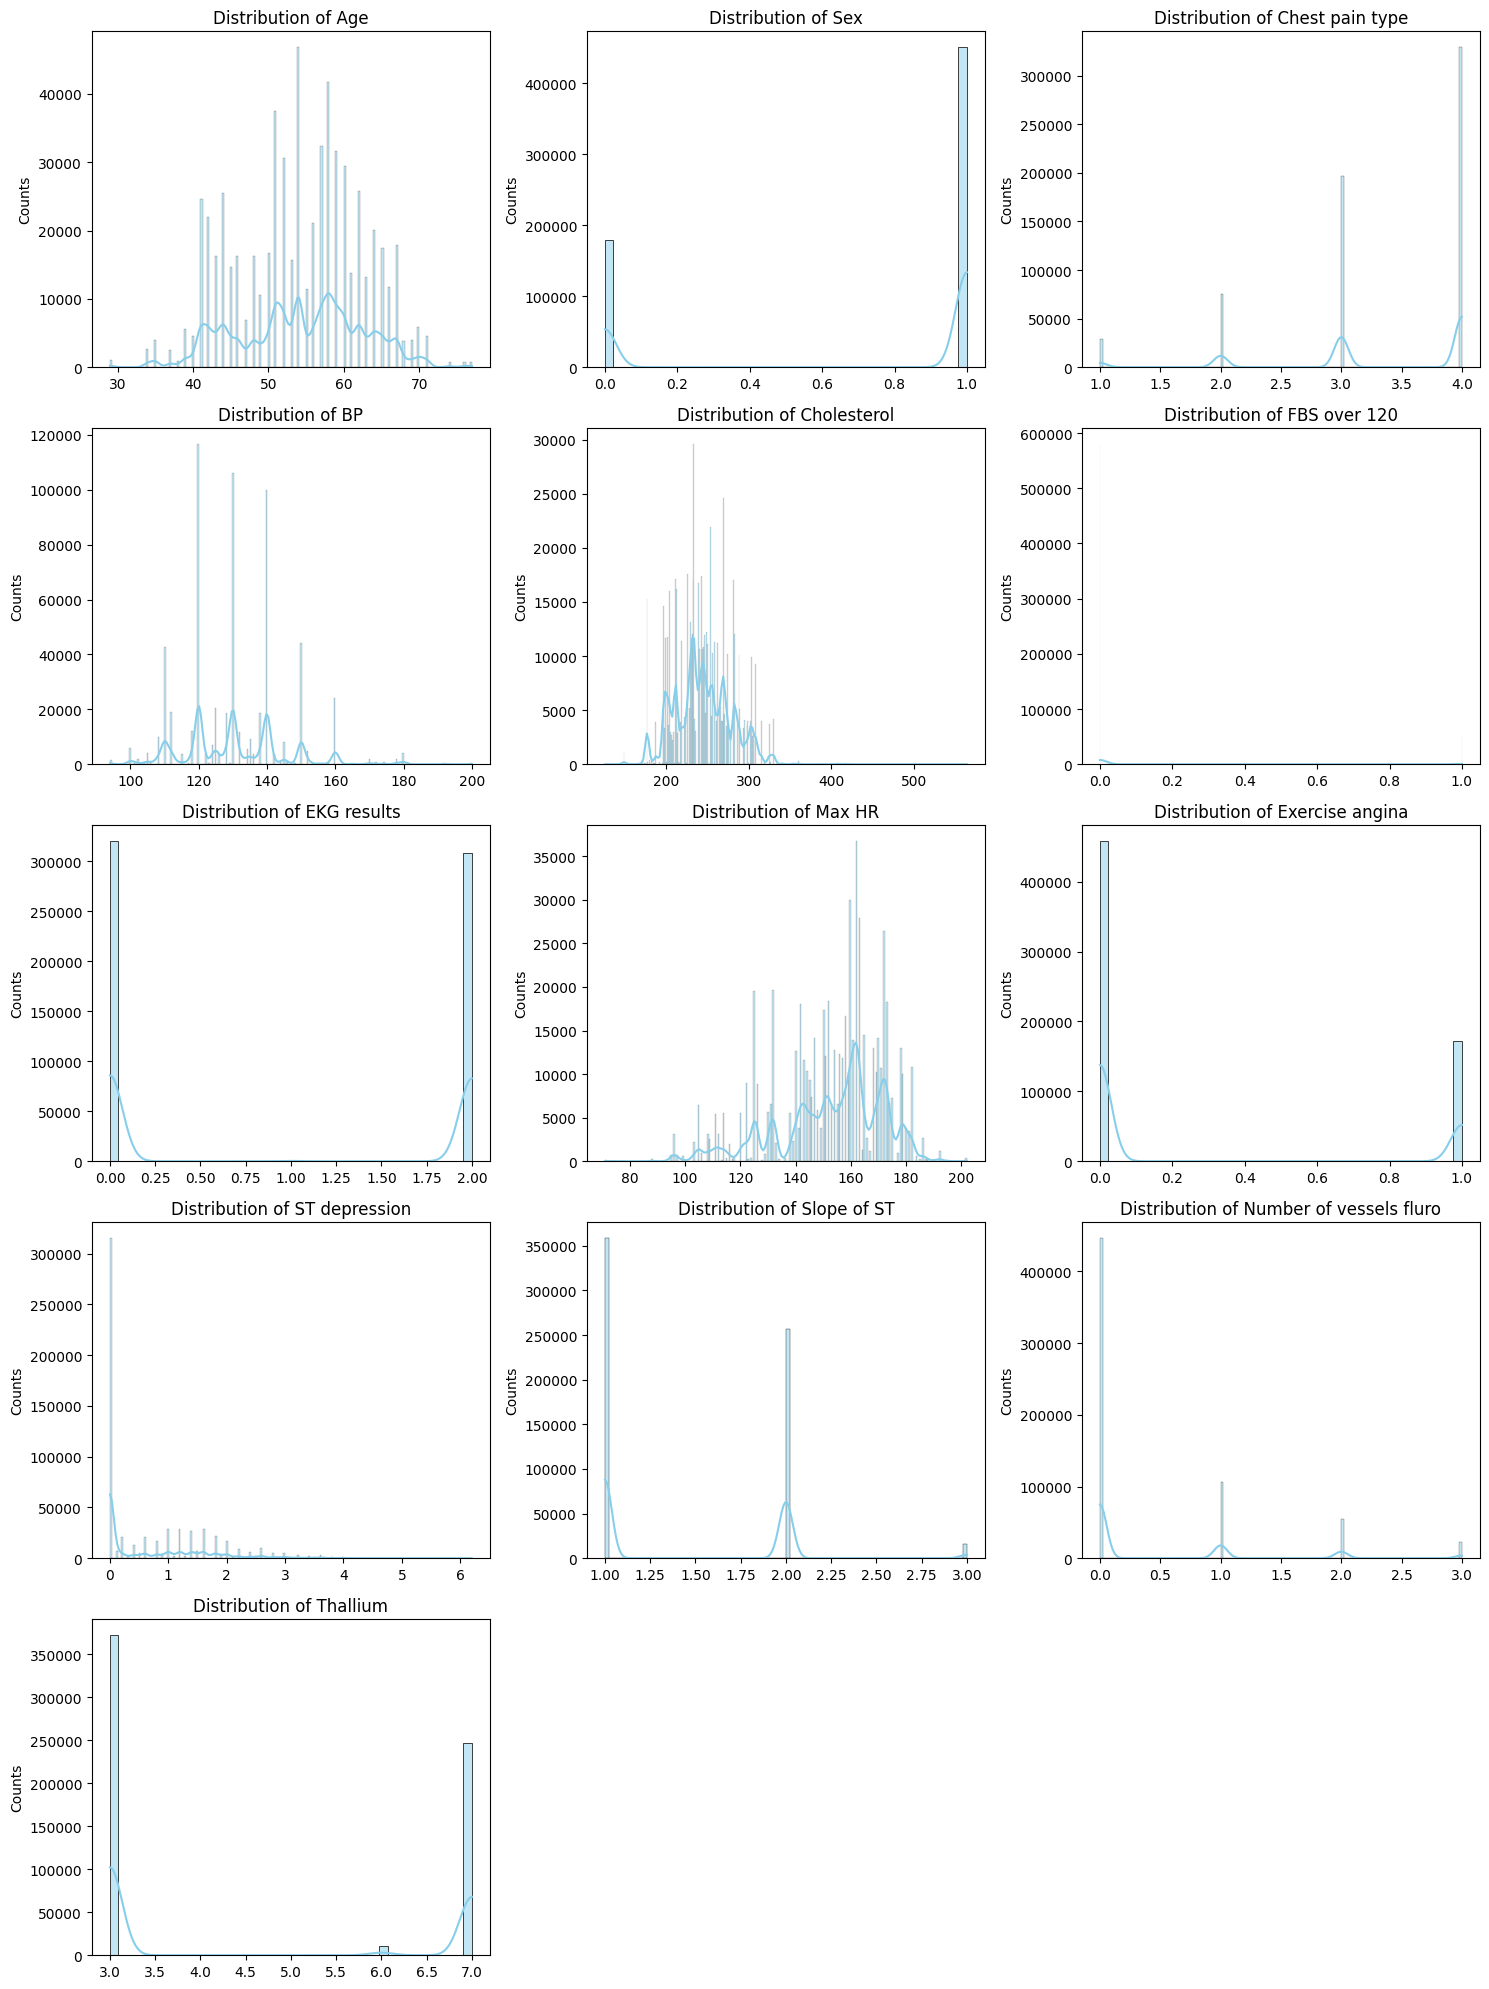

In [56]:
# 타겟 분포 시각화
target_col = "Heart Disease"
features = [i for i in train.columns[1:] if i != target_col]

# 한 줄에 보여줄 그래프 개수 설정
cols = 3
rows = math.ceil(len(features) / cols)

# 서브플롯 생성 (전체 크기 조절)
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten() # 2차원 배열을 1차원으로 펼쳐서 반복문 돌리기 편하게 함

for i, col in enumerate(features):
    # 최신 seaborn의 histplot 사용 (밀도 곡선 포함 가능)
    sns.histplot(train[col], ax=axes[i], kde=True, color='skyblue')
    
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Counts")

# 남는 빈 그래프(공백) 제거
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()

In [98]:
# # x, y 분리
X = train.drop(['Heart Disease', 'id'], axis=1)
y = train['Heart Disease']
id_cols = [col for col in train.columns if 'id' in col.lower()]

X_test = test.drop('id', axis=1)

In [57]:
# 파이프라인 생성
def create_pipeline(model, scaler=None):
  """모델과 스케일러를 결합한 파이프라인 생성"""
  if scaler:
      return Pipeline([
          ('scaler', scaler),
          ('model', model)
      ])
  return Pipeline([('model', model)])

In [80]:
# WandB 로깅
wandb.log({
    "data/train_samples": len(X),
    "data/num_features": len(X.columns),
    "data/num_categorical": len(cat_cols),
    "data/num_numerical": len(num_cols),
    "data/target_distribution": target_dist.to_dict()
})

# Stratified K-Fold 및 평가 함수 설정

In [ ]:
# Stratified K-Fold 설정 (클래스 비율 유지)
N_SPLITS = 5
RANDOM_STATE = 42

skf = StratifiedKFold(
    n_splits=N_SPLITS, 
    shuffle=True, 
    random_state=RANDOM_STATE
)

print(f"✅ Stratified {N_SPLITS}-Fold 교차 검증 설정")
print(f"  • 클래스 비율을 유지하여 데이터 분할")
print(f"  • 불균형 데이터셋에 적합한 검증 방법")

# 평가 함수 정의
def evaluate_model_cv(model, X, y, cv_folds, model_name="Model"):
    """
    교차 검증을 통한 모델 평가
    
    Parameters:
    - model: 학습할 모델 (Pipeline)
    - X, y: 학습 데이터
    - cv_folds: 교차 검증 폴드
    - model_name: 모델 이름
    
    Returns:
    - avg_scores: 평균 점수 딕셔너리
    - fold_scores: 각 폴드별 점수 리스트
    """
    
    print(f"\n{'='*60}")
    print(f"{model_name} 교차 검증 평가")
    print(f"{'='*60}")
    
    # 점수 저장용 딕셔너리
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': []
    }
    
    # 각 폴드별 평가
    for fold, (train_idx, val_idx) in enumerate(cv_folds.split(X, y), 1):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # 모델 학습 (Pipeline이므로 자동으로 전처리 적용)
        model.fit(X_fold_train, y_fold_train)
        
        # 예측
        y_pred = model.predict(X_fold_val)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        
        # 메트릭 계산
        scores['accuracy'].append(accuracy_score(y_fold_val, y_pred))
        scores['precision'].append(precision_score(y_fold_val, y_pred, zero_division=0))
        scores['recall'].append(recall_score(y_fold_val, y_pred, zero_division=0))
        scores['f1'].append(f1_score(y_fold_val, y_pred, zero_division=0))
        scores['roc_auc'].append(roc_auc_score(y_fold_val, y_pred_proba))
        
        print(f"  Fold {fold}: Acc={scores['accuracy'][-1]:.4f}, "
              f"F1={scores['f1'][-1]:.4f}, AUC={scores['roc_auc'][-1]:.4f}")
    
    # 평균 및 표준편차 계산
    avg_scores = {metric: np.mean(values) for metric, values in scores.items()}
    std_scores = {metric: np.std(values) for metric, values in scores.items()}
    
    print(f"\n {model_name} - 교차 검증 결과:")
    print(f"  • Accuracy: {avg_scores['accuracy']:.4f} (±{std_scores['accuracy']:.4f})")
    print(f"  • Precision: {avg_scores['precision']:.4f} (±{std_scores['precision']:.4f})")
    print(f"  • Recall: {avg_scores['recall']:.4f} (±{std_scores['recall']:.4f})")
    print(f"  • F1-Score: {avg_scores['f1']:.4f} (±{std_scores['f1']:.4f})")
    print(f"  • ROC-AUC: {avg_scores['roc_auc']:.4f} (±{std_scores['roc_auc']:.4f})")
    
    return avg_scores, scores

print("\n✅ 평가 함수 정의 완료!")

✅ Stratified 5-Fold 교차 검증 설정
  • 클래스 비율을 유지하여 데이터 분할
  • 불균형 데이터셋에 적합한 검증 방법

✅ 평가 함수 정의 완료!


# 모델별 파이프라인 정의 (스케일링 전략 차별화)

In [ ]:
# 모델 파이프라인 딕셔너리
models_pipelines = {}

# 1. Logistic Regression (스케일링 필수)
print("Logistic Regression Pipeline:")
print("  • StandardScaler + LogisticRegression")
print("  • 이유: 선형 모델은 feature scale에 민감함")

models_pipelines['LogisticRegression'] = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'  # 클래스 불균형 처리
    ))
])

# 2. Decision Tree (스케일링 불필요)
print("\nDecision Tree Pipeline:")
print("  • DecisionTreeClassifier (스케일링 없음)")
print("  • 이유: 트리 모델은 feature scale에 무관함")

models_pipelines['DecisionTree'] = Pipeline([
    ('classifier', DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight='balanced'
    ))
])

# 3. XGBoost (스케일링 불필요)
if XGBOOST_AVAILABLE:
    print("\n XGBoost Pipeline:")
    print("  • XGBClassifier (스케일링 없음)")
    print("  • 이유: 부스팅 트리 모델은 feature scale에 무관함")
    
    models_pipelines['XGBoost'] = Pipeline([
        ('classifier', XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False,
            n_estimators=100
        ))
    ])

# 4. LightGBM (스케일링 불필요)
if LIGHTGBM_AVAILABLE:
    print("\n LightGBM Pipeline:")
    print("  • LGBMClassifier (스케일링 없음)")
    print("  • 이유: 부스팅 트리 모델은 feature scale에 무관함")
    
    models_pipelines['LightGBM'] = Pipeline([
        ('classifier', LGBMClassifier(
            random_state=RANDOM_STATE,
            verbose=-1,
            class_weight='balanced',
            n_estimators=100
        ))
    ])

# 5. CatBoost (스케일링 불필요)
# if CATBOOST_AVAILABLE:
#     print("\n📋 CatBoost Pipeline:")
#     print("  • CatBoostClassifier (스케일링 없음)")
#     print("  • 이유: 부스팅 트리 모델은 feature scale에 무관함")
    
#     models_pipelines['CatBoost'] = Pipeline([
#         ('classifier', CatBoostClassifier(
#             random_state=RANDOM_STATE,
#             verbose=0,
#             auto_class_weights='Balanced',
#             iterations=100
#         ))
#     ])

print(f"\n✅ {len(models_pipelines)}개 모델 파이프라인 생성 완료:")
for model_name in models_pipelines.keys():
    print(f"  • {model_name}")

print(f"\n💡 Pipeline의 중요성:")
print(f"  • Data Leakage 방지: 검증 데이터에 학습 데이터의 통계량이 누출되지 않음")
print(f"  • 일관된 전처리: 학습과 예측 시 동일한 전처리 과정 보장")
print(f"  • 코드 간소화: 전처리와 모델링을 하나의 객체로 관리")

Logistic Regression Pipeline:
  • StandardScaler + LogisticRegression
  • 이유: 선형 모델은 feature scale에 민감함

Decision Tree Pipeline:
  • DecisionTreeClassifier (스케일링 없음)
  • 이유: 트리 모델은 feature scale에 무관함

 XGBoost Pipeline:
  • XGBClassifier (스케일링 없음)
  • 이유: 부스팅 트리 모델은 feature scale에 무관함

 LightGBM Pipeline:
  • LGBMClassifier (스케일링 없음)
  • 이유: 부스팅 트리 모델은 feature scale에 무관함

✅ 4개 모델 파이프라인 생성 완료:
  • LogisticRegression
  • DecisionTree
  • XGBoost
  • LightGBM

💡 Pipeline의 중요성:
  • Data Leakage 방지: 검증 데이터에 학습 데이터의 통계량이 누출되지 않음
  • 일관된 전처리: 학습과 예측 시 동일한 전처리 과정 보장
  • 코드 간소화: 전처리와 모델링을 하나의 객체로 관리


# GridSearchCV 하이퍼파라미터 그리드 정의

In [ ]:
# 하이퍼파라미터 그리드 (실용적인 범위로 설정)
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l2'],  # l1은 solver 제한으로 제외
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    
    'DecisionTree': {
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [10, 20, 30],
        'classifier__min_samples_leaf': [5, 10, 15],
        'classifier__criterion': ['gini', 'entropy']
    }
}

# XGBoost 파라미터 (사용 가능한 경우)
if XGBOOST_AVAILABLE:
    param_grids['XGBoost'] = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }

# LightGBM 파라미터 (사용 가능한 경우)
if LIGHTGBM_AVAILABLE:
    param_grids['LightGBM'] = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7, -1],
        'classifier__num_leaves': [31, 63, 127]
    }

# CatBoost 파라미터 (사용 가능한 경우)
# if CATBOOST_AVAILABLE:
#     param_grids['CatBoost'] = {
#         'classifier__iterations': [100, 200, 300],
#         'classifier__learning_rate': [0.01, 0.1, 0.2],
#         'classifier__depth': [4, 6, 8]
#     }

print(f"{len(param_grids)}개 모델의 하이퍼파라미터 그리드 정의 완료")

for model_name, grid in param_grids.items():
    total_combinations = np.prod([len(values) for values in grid.values()])
    print(f"  • {model_name}: {len(grid)}개 파라미터, {total_combinations}개 조합")

print(f"\nGridSearchCV 예상 실행 시간:")
print(f"  • 총 조합 수 × {N_SPLITS} folds × 모델 수")
print(f"  • 병렬 처리(n_jobs=-1)로 속도 향상")

4개 모델의 하이퍼파라미터 그리드 정의 완료
  • LogisticRegression: 3개 파라미터, 10개 조합
  • DecisionTree: 4개 파라미터, 72개 조합
  • XGBoost: 5개 파라미터, 108개 조합
  • LightGBM: 4개 파라미터, 108개 조합

GridSearchCV 예상 실행 시간:
  • 총 조합 수 × 5 folds × 모델 수
  • 병렬 처리(n_jobs=-1)로 속도 향상


# GridSearchCV 실행 및 베이스라인 비교

In [ ]:
# 결과 저장용
baseline_results = {}
tuned_results = {}
best_models = {}

for model_name, pipeline in models_pipelines.items():
    print(f"\n{'='*60}")
    print(f"🔍 {model_name} 처리 중...")
    print(f"{'='*60}")
    
    start_time = pd.Timestamp.now()
    
    # 1단계: 베이스라인 성능 평가
    print(f"\n1️⃣ 베이스라인 성능 평가:")
    baseline_scores, _ = evaluate_model_cv(pipeline, X_train, y_train, skf, f"{model_name} (Baseline)")
    baseline_results[model_name] = baseline_scores
    
    # 2단계: GridSearchCV 하이퍼파라미터 튜닝
    if model_name in param_grids:
        print(f"\n2️⃣ GridSearchCV 하이퍼파라미터 튜닝:")
        
        # GridSearchCV 설정
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grids[model_name],
            cv=skf,
            scoring='roc_auc',  # 불균형 데이터에 적합한 메트릭
            n_jobs=-1,          # 모든 CPU 코어 사용
            verbose=1,
            return_train_score=True
        )
        
        # 그리드 서치 실행
        grid_search.fit(X_train, y_train)
        
        # 최적 모델 평가
        best_pipeline = grid_search.best_estimator_
        tuned_scores, _ = evaluate_model_cv(best_pipeline, X_train, y_train, skf, f"{model_name} (Tuned)")
        
        # 결과 저장
        tuned_results[model_name] = {
            **tuned_scores,
            'best_params': grid_search.best_params_,
            'best_cv_score': grid_search.best_score_
        }
        best_models[model_name] = best_pipeline
        
        print(f"\n🎯 최적 파라미터:")
        for param, value in grid_search.best_params_.items():
            print(f"  • {param}: {value}")
        
        print(f"\n📈 성능 개선:")
        baseline_auc = baseline_results[model_name]['roc_auc']
        tuned_auc = tuned_scores['roc_auc']
        improvement = tuned_auc - baseline_auc
        improvement_pct = (improvement / baseline_auc) * 100
        
        print(f"  • Baseline AUC: {baseline_auc:.4f}")
        print(f"  • Tuned AUC: {tuned_auc:.4f}")
        print(f"  • Improvement: {improvement:+.4f} ({improvement_pct:+.2f}%)")
        
    else:
        print(f"\n⚠️ {model_name}의 파라미터 그리드가 정의되지 않음 - 베이스라인만 사용")
        best_models[model_name] = pipeline
        # 전체 데이터로 학습
        pipeline.fit(X_train, y_train)
    
    elapsed_time = (pd.Timestamp.now() - start_time).total_seconds()
    print(f"\n⏱️ 총 소요 시간: {elapsed_time:.1f}초")
    
    # WandB 로깅
    wandb.log({
        f"{model_name}/baseline_roc_auc": baseline_results[model_name]['roc_auc'],
        f"{model_name}/baseline_f1": baseline_results[model_name]['f1'],
        f"{model_name}/training_time": elapsed_time
    })
    
    if model_name in tuned_results:
        wandb.log({
            f"{model_name}/tuned_roc_auc": tuned_results[model_name]['roc_auc'],
            f"{model_name}/tuned_f1": tuned_results[model_name]['f1'],
            f"{model_name}/improvement_pct": improvement_pct
        })

print("\n" + "=" * 80)
print("✅ 모든 모델 처리 완료!")
print("=" * 80)

# 결과 분석 및 시각화

In [ ]:
# 결과 DataFrame 생성
comparison_data = []

for model_name in baseline_results.keys():
    baseline_auc = baseline_results[model_name]['roc_auc']
    baseline_f1 = baseline_results[model_name]['f1']
    
    if model_name in tuned_results:
        tuned_auc = tuned_results[model_name]['roc_auc']
        tuned_f1 = tuned_results[model_name]['f1']
        improvement = tuned_auc - baseline_auc
        improvement_pct = (improvement / baseline_auc) * 100
    else:
        tuned_auc = baseline_auc
        tuned_f1 = baseline_f1
        improvement = 0
        improvement_pct = 0
    
    comparison_data.append({
        'Model': model_name,
        'Baseline_AUC': baseline_auc,
        'Baseline_F1': baseline_f1,
        'Tuned_AUC': tuned_auc,
        'Tuned_F1': tuned_f1,
        'AUC_Improvement': improvement,
        'Improvement_Pct': improvement_pct
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Tuned_AUC', ascending=False)

print("\n🏆 모델 성능 순위 (ROC-AUC 기준):")
display(comparison_df.style.background_gradient(
    cmap='RdYlGn', 
    subset=['Tuned_AUC', 'Tuned_F1', 'AUC_Improvement']
))

# 최고 성능 모델 선택
best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['Tuned_AUC']

print(f"\n🥇 최고 성능 모델: {best_model_name}")
print(f"   ROC-AUC: {best_auc:.4f}")

# 시각화 1: 베이스라인 vs 튜닝 후 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# AUC 비교
x = np.arange(len(comparison_df))
width = 0.35

bars1 = axes[0].bar(x - width/2, comparison_df['Baseline_AUC'], width, label='Baseline', color='lightblue', alpha=0.8)
bars2 = axes[0].bar(x + width/2, comparison_df['Tuned_AUC'], width, label='Tuned', color='darkblue', alpha=0.8)

axes[0].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[0].set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
axes[0].set_title('ROC-AUC: Baseline vs Tuned', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# 값 표시
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 개선율 차트
bars3 = axes[1].bar(comparison_df['Model'], comparison_df['Improvement_Pct'], color='green', alpha=0.7)
axes[1].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Performance Improvement (%)', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# 개선율 값 표시
for bar, value in zip(bars3, comparison_df['Improvement_Pct']):
    if value != 0:
        axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'model_comparison_gridsearch.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# WandB에 시각화 로깅
wandb.log({"model_comparison_gridsearch": wandb.Image(plt)})

# 시각화 2: 상위 3개 모델의 상세 메트릭 비교
top_3_models = comparison_df.head(3)

fig, ax = plt.subplots(figsize=(12, 8))

metrics = ['Tuned_AUC', 'Tuned_F1']
metric_labels = ['ROC-AUC', 'F1-Score']

x = np.arange(len(top_3_models))
width = 0.35

for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    bars = ax.bar(x + i * width, top_3_models[metric], width, label=label, alpha=0.8)
    
    # 값 표시
    for bar, value in zip(bars, top_3_models[metric]):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Top 3 Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Top 3 Models - Detailed Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x + width/2)
ax.set_xticklabels(top_3_models['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'top3_models_metrics.png', 
            dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"top3_models_metrics": wandb.Image(plt)})

print(f"\n💾 결과 저장:")
comparison_df.to_csv(project_root / 'outputs' / 'gridsearch_results.csv', index=False)
print(f"  • 비교 결과: outputs/gridsearch_results.csv")

# 최종 모델 선택 및 테스트 예측

🏆 선택된 최종 모델: XGBoost
  • ROC-AUC: 0.9554
  • 최적 하이퍼파라미터:
    - classifier__colsample_bytree: 1.0
    - classifier__learning_rate: 0.2
    - classifier__max_depth: 3
    - classifier__n_estimators: 300
    - classifier__subsample: 1.0

🔄 전체 훈련 데이터로 최종 모델 학습 중...
✅ 최종 학습 완료!

🔮 테스트 데이터 예측 중...
✅ 예측 완료!
  • 예측 샘플 수: 270000
  • 클래스 0 예측: 150542
  • 클래스 1 예측: 119458

📝 제출 파일 생성:
  • 타겟 컬럼: Heart Disease
✅ 제출 파일 저장: c:\Users\ico26\kaggle\Heart Disease\outputs\submissions\submission_xgboost_gridsearch.csv

👀 제출 파일 미리보기:


,id,Heart Disease
0,630000,1
1,630001,0
2,630002,1
3,630003,0
4,630004,0
5,630005,1
6,630006,0
7,630007,1
8,630008,1
9,630009,0


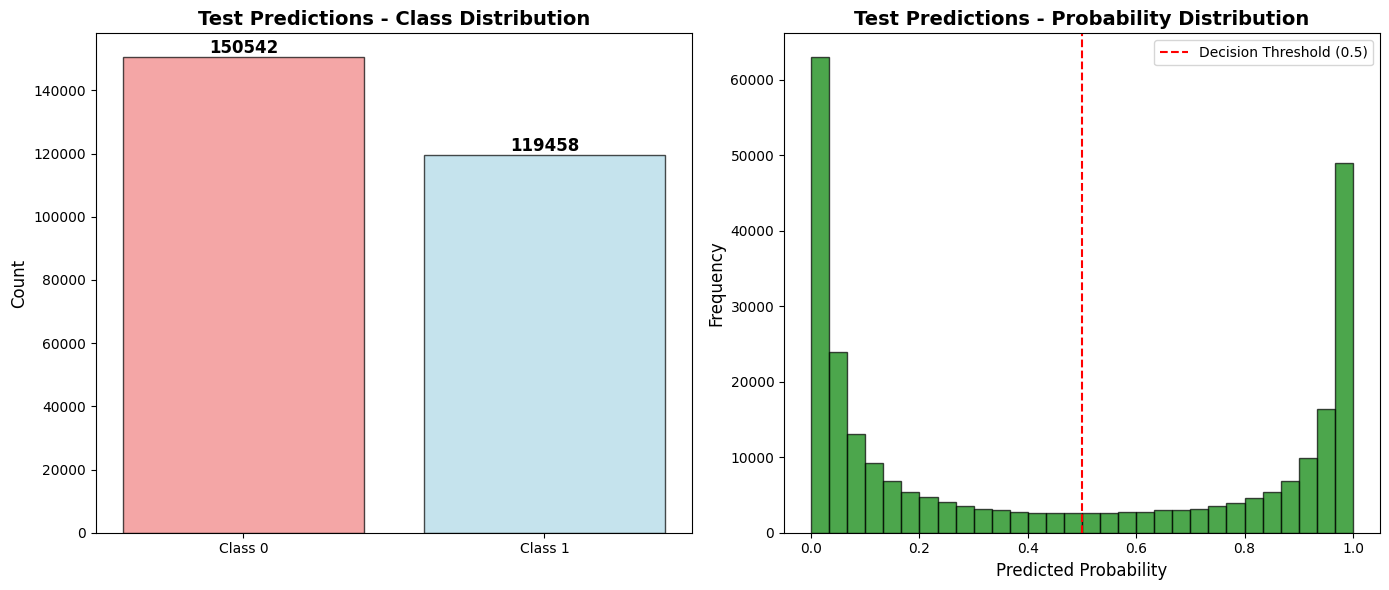

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Linked 1 file into the W&B run directory (hardlinks); call wandb.save again to sync new files.
wandb: WARNING Linked 1 file into the W&B run directory (hardlinks); call wandb.save again to sync new files.



💾 최종 모델 저장: c:\Users\ico26\kaggle\Heart Disease\outputs\models\best_model_xgboost_gridsearch.pkl

📊 WandB에 업로드된 파일:
  • 제출 파일: submission_xgboost_gridsearch.csv
  • 모델 파일: best_model_xgboost_gridsearch.pkl


<Figure size 640x480 with 0 Axes>

In [100]:
# 최고 성능 모델 선택
best_model = best_models[best_model_name]

print(f"🏆 선택된 최종 모델: {best_model_name}")
print(f"  • ROC-AUC: {best_auc:.4f}")

if best_model_name in tuned_results:
    print(f"  • 최적 하이퍼파라미터:")
    for param, value in tuned_results[best_model_name]['best_params'].items():
        print(f"    - {param}: {value}")

# 전체 훈련 데이터로 최종 학습
print(f"\n🔄 전체 훈련 데이터로 최종 모델 학습 중...")
best_model.fit(X, y)
print("✅ 최종 학습 완료!")

# 테스트 데이터 예측
print(f"\n🔮 테스트 데이터 예측 중...")
test_predictions = best_model.predict(X_test)
test_predictions_proba = best_model.predict_proba(X_test)[:, 1]

print(f"✅ 예측 완료!")
print(f"  • 예측 샘플 수: {len(test_predictions)}")
print(f"  • 클래스 0 예측: {np.sum(test_predictions == 0)}")
print(f"  • 클래스 1 예측: {np.sum(test_predictions == 1)}")

# 제출 파일 생성
submission = submission_df.copy()

# 제출 파일의 타겟 컬럼 확인
submission_target_col = [col for col in submission.columns 
                        if col not in id_cols and col != 'id'][0]

print(f"\n📝 제출 파일 생성:")
print(f"  • 타겟 컬럼: {submission_target_col}")

# 대회 요구사항에 따라 클래스 또는 확률 선택
submission[submission_target_col] = test_predictions  # 클래스 예측
# submission[submission_target_col] = test_predictions_proba  # 확률 예측 (필요시)

# 제출 파일 저장
submission_filename = f'submission_{best_model_name.lower()}_gridsearch.csv'
submission_path = project_root / 'outputs' / 'submissions' / submission_filename
submission.to_csv(submission_path, index=False)

print(f"✅ 제출 파일 저장: {submission_path}")

# 제출 파일 미리보기
print(f"\n👀 제출 파일 미리보기:")
display(submission.head(10))

# 예측 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 클래스 분포
class_counts = np.bincount(test_predictions)
axes[0].bar(['Class 0', 'Class 1'], class_counts, color=['lightcoral', 'lightblue'], alpha=0.7, edgecolor='black')
axes[0].set_title('Test Predictions - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)
for i, count in enumerate(class_counts):
    axes[0].text(i, count, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

# 확률 분포
axes[1].hist(test_predictions_proba, bins=30, color='green', alpha=0.7, edgecolor='black')
axes[1].set_title('Test Predictions - Probability Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Probability', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
axes[1].legend()

plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'test_predictions_distribution.png', 
            dpi=300, bbox_inches='tight')
plt.show()

wandb.log({"test_predictions_distribution": wandb.Image(plt)})

# 모델 저장
import joblib
model_filename = f'best_model_{best_model_name.lower()}_gridsearch.pkl'
model_path = project_root / 'outputs' / 'models' / model_filename
joblib.dump(best_model, model_path)

print(f"\n💾 최종 모델 저장: {model_path}")

# WandB에 파일들 업로드
wandb.save(str(submission_path))
wandb.save(str(model_path))

print(f"\n📊 WandB에 업로드된 파일:")
print(f"  • 제출 파일: {submission_filename}")
print(f"  • 모델 파일: {model_filename}")

# 최종 요약 및 WandB 종료

In [102]:
# 프로젝트 요약
print(f"\n🎯 프로젝트 개요:")
print(f"  • 데이터: 심장질환 예측 (Train: {len(X):,}, Test: {len(X_test):,})")
print(f"  • Features: {len(X.columns)}개")
print(f"  • 타겟: {target_col}")
print(f"  • 검증 방법: Stratified {N_SPLITS}-Fold Cross Validation")

print(f"\n🤖 학습된 모델:")
for i, (model_name, scores) in enumerate(baseline_results.items(), 1):
    baseline_auc = scores['roc_auc']
    if model_name in tuned_results:
        tuned_auc = tuned_results[model_name]['roc_auc']
        improvement = tuned_auc - baseline_auc
        print(f"  {i}. {model_name}: {baseline_auc:.4f} → {tuned_auc:.4f} ({improvement:+.4f})")
    else:
        print(f"  {i}. {model_name}: {baseline_auc:.4f} (베이스라인만)")

print(f"\n🏆 최종 선택 모델:")
print(f"  • 모델: {best_model_name}")
print(f"  • ROC-AUC: {best_auc:.4f}")
if best_model_name in tuned_results:
    print(f"  • F1-Score: {tuned_results[best_model_name]['f1']:.4f}")
    print(f"  • Accuracy: {tuned_results[best_model_name]['accuracy']:.4f}")

print(f"\n💾 생성된 파일:")
print(f"  • 모델: {model_path}")
print(f"  • 제출 파일: {submission_path}")
print(f"  • 결과 분석: outputs/gridsearch_results.csv")

print(f"\n📊 생성된 시각화:")
print(f"  • 모델 비교: outputs/model_comparison_gridsearch.png")
print(f"  • 상위 3개 모델: outputs/top3_models_metrics.png")
print(f"  • 예측 분포: outputs/test_predictions_distribution.png")

print(f"\n🔧 사용된 기술:")
print(f"  • Pipeline: Data leakage 방지 및 전처리 자동화")
print(f"  • StandardScaler: Logistic Regression에만 적용 (모델별 차별화)")
print(f"  • StratifiedKFold: 클래스 불균형 데이터에 적합한 교차 검증")
print(f"  • GridSearchCV: 체계적인 하이퍼파라미터 최적화")

# 최종 메트릭 WandB 로깅
final_metrics = {
    "final/best_model": best_model_name,
    "final/best_roc_auc": best_auc,
    "final/num_models_tested": len(models_pipelines),
    "final/num_features": len(X.columns),
    "final/train_samples": len(X),
    "final/test_samples": len(X_test)
}

if best_model_name in tuned_results:
    final_metrics.update({
        "final/best_f1": tuned_results[best_model_name]['f1'],
        "final/best_accuracy": tuned_results[best_model_name]['accuracy']
    })

wandb.log(final_metrics)

# WandB 실험 종료
wandb.finish()

print(f"\n✅ WandB 실험 추적 완료!")
print(f"🔗 실험 결과 확인: {run.url if run.url else f'https://wandb.ai/{WANDB_ENTITY}/{WANDB_PROJECT}'}")

print(f"\n" + "=" * 80)
print("🎉 모든 작업이 성공적으로 완료되었습니다!")
print("🚀 이제 Kaggle에 제출하여 리더보드 점수를 확인해보세요!")
print("=" * 80)


🎯 프로젝트 개요:
  • 데이터: 심장질환 예측 (Train: 630,000, Test: 270,000)
  • Features: 13개
  • 타겟: Heart Disease
  • 검증 방법: Stratified 5-Fold Cross Validation

🤖 학습된 모델:
  1. LogisticRegression: 0.9505 → 0.9505 (+0.0000)
  2. DecisionTree: 0.9492 → 0.9493 (+0.0001)
  3. XGBoost: 0.9547 → 0.9554 (+0.0007)
  4. LightGBM: 0.9548 → 0.9554 (+0.0006)

🏆 최종 선택 모델:
  • 모델: XGBoost
  • ROC-AUC: 0.9554
  • F1-Score: 0.8747
  • Accuracy: 0.8886

💾 생성된 파일:
  • 모델: c:\Users\ico26\kaggle\Heart Disease\outputs\models\best_model_xgboost_gridsearch.pkl
  • 제출 파일: c:\Users\ico26\kaggle\Heart Disease\outputs\submissions\submission_xgboost_gridsearch.csv
  • 결과 분석: outputs/gridsearch_results.csv

📊 생성된 시각화:
  • 모델 비교: outputs/model_comparison_gridsearch.png
  • 상위 3개 모델: outputs/top3_models_metrics.png
  • 예측 분포: outputs/test_predictions_distribution.png

🔧 사용된 기술:
  • Pipeline: Data leakage 방지 및 전처리 자동화
  • StandardScaler: Logistic Regression에만 적용 (모델별 차별화)
  • StratifiedKFold: 클래스 불균형 데이터에 적합한 교차 검증
  • GridSearchC

DecisionTree/baseline_f1,▁
DecisionTree/baseline_roc_auc,▁
DecisionTree/improvement_pct,▁
DecisionTree/training_time,▁
DecisionTree/tuned_f1,▁
DecisionTree/tuned_roc_auc,▁
LightGBM/baseline_f1,▁
LightGBM/baseline_roc_auc,▁
LightGBM/improvement_pct,▁
LightGBM/training_time,▁
+25,...



✅ WandB 실험 추적 완료!
🔗 실험 결과 확인: https://wandb.ai/icoghkdqh742-/heart-disease-prediction/runs/ztv9a8fs

🎉 모든 작업이 성공적으로 완료되었습니다!
🚀 이제 Kaggle에 제출하여 리더보드 점수를 확인해보세요!
